# Polscope with phase reconstruction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift

import pickle
import waveorders as wo

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


### Load data

In [2]:
# Save simulations

f = open('simulation_data.pckl', 'rb')
I_meas, Stokes_out, lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi = pickle.load(f)
f.close()


### Stokes vector/Polarization reconstruction

In [4]:
_, _, N, M = I_meas.shape
LRHC        = 'RHC'               
bg_option   = 'global'            

setup = wo.waveorders_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, LRHC, bg_option)
S_image_recon = setup.Stokes_recon(I_meas)
S_image_tm = setup.Stokes_transform(S_image_recon)
Recon_para =setup.Polarization_recon(S_image_tm)

In [5]:
wo.parallel_4D_viewer(S_image_recon, num_col=2, size=5)

interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorders.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [6]:
wo.parallel_4D_viewer(Recon_para, num_col=2, size=5)

interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorders.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

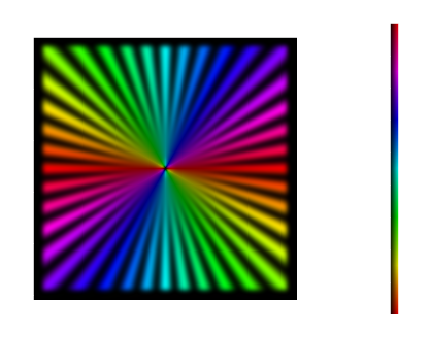

In [7]:
wo.plot_hsv([Recon_para[2,1], Recon_para[2,0]])

In [7]:
wo.hsv_stack_viewer([Recon_para[:,1], Recon_para[:,0]])

interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorders.visual.hsv_stack_viewer.<locals>.interact_plot_hsv(stack_idx)>

## Phase reconstruction with $S_0$

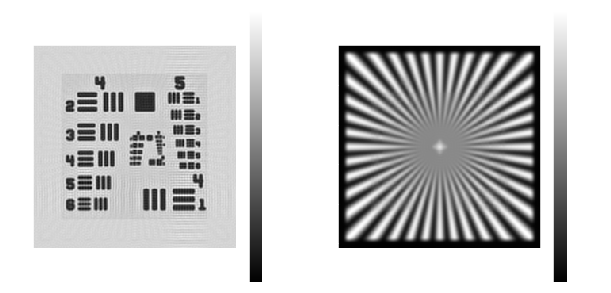

In [8]:

reg = 1e-6
S0_stack = S_image_recon[:,0,:,:].copy()

mu_sample, phi_sample = setup.Phase_recon(S0_stack, reg)

wo.plot_multicolumn(np.array([mu_sample, phi_sample]), num_col=2, size=5, \
                    set_title=True, titles = ['Reconstructed absorption', 'Reconstructed phase'])